# Actividad 1

## Requisitos

- Habitación de MxN espacios.
- Número de agentes.
- Porcentaje de celdas inicialmente sucias.
- Tiempo máximo de ejecución.

## Instrucciones

- Inicializa las celdas sucias (ubicaciones aleatorias).
- Todos los agentes empiezan en posiciones aleatorias.
- En cada paso de tiempo:
    - Si la celda está sucia, entonces aspira.
    - Si la celda está limpia, 
        - El agente elije mover a una nueva celda, usando esta selección: norte, este, sur, oeste.
        - El agente se moverá a esa celda siempre y cuando no la haya visitado antes. 
        - Si no tiene opciones para moverse, el agente se moverá a la celda que previamente haya visitado.
        - Si ya no tiene más opciones, el agente se detiene.
- Se ejecuta el tiempo máximo establecido.

Empleando siempre la misma cantidad de agentes (más de 2), determina:

- ¿Cuál es el tiempo necesario hasta que todas las celdas estén limpias?
- Empleando un número máximo de iteraciones, ¿cuál es el porcentaje de celdas limpias después del termino de la simulación?
- En ambos casos, ¿cuál es la cantidad de movimientos realizados por los agentes?

Desarrolla un documento analizando los resultados obtenidos.

## Evaluación 

45% - El código cumple correctamente con la funcionalidad requerida por parte de la actividad.
10% - El código deberá seguir los lineamientos estipulados en el estándar de codificación: liga_estándar_codificación
Download liga_estándar_codificación.
45% - El informe presenta un análisis del problema planteado, así como las conclusiones obtenidas del mismo.

In [19]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Necesitamos agentes por celdas, usamos MultiGrid
from mesa.space import MultiGrid

# Con ''RandomActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
# Número de iteraciones
MAXVAL = 10000


In [20]:
class VaccumCleaner(Agent):
    # initialize class, define id and space occupied (model)
    def __init__(self, id, model):
        super().__init__(id, model)

        def check_up():

        def check_upleft():

        def check_upright():

        def check_down():

        def check_downleft():

        def check_downright():

        def check_left():
            
        def check_right():
            
        # check for dirt below and surrounding
        def check_dirt():
            if self.model.cells[[self.pos[0]][self.pos[1]]] == 1:
                return self.pos[0], self.pos[1]
            else 
        
        def move_to_dirt(self, x_pos, y_pos):
            self.model.grid.move_agent(self, (x_pos, y_pos))

        def clean_cell(self):
            if self.model.cells[[self.pos[0]][self.pos[1]]] == 1:
                self.model.cells[[self.pos[0]][self.pos[1]]] = 0

        # define what is done on each step
        
        def step(self):
            clean_cell(self)
            move_to_dirt(self, check_dirt())

In [21]:
# save a copy of the matrix
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
        if not model.grid.is_cell_empty((x,y)):
            grid[x][y] = 2
        else:
            grid[x][y] = model.cells[x][y]
    return grid

In [22]:
class VaccumCleanerModel(Model):
    # initialize class, define space size
    def __init__(self, width, height, num_agents = 2, dirty_cell_percentage = 0.8):
        self.num_agents = num_agents
        self.dirty_cell_percentage = dirty_cell_percentage
        
        # Grid does not wrap-around
        self.grid = MultiGrid(width, height, False)
        
        # Define the activation, generate in each iteration a random model and make a new step
        self.schedule = RandomActivation(self)
        
        # Data collector
        self.datacollector = DataCollector(model_reporters = {"Grid" : get_grid})
        
        # Generate matrix of zeros
        self.cells = np.zeros((width, height))
        amount = int((width*height)*self.dirty_cell_percentage)
        for i in range (amount):
            finished = False
            while not finished:
                x = int(np.random.random() * MAXVAL) % width
                y = int(np.random.random() * MAXVAL) % height
                if self.cells[x][y] == 0:
                    self.cells[x][y] = 1
                    finished = True
        
        # Generate agents in empty cells
        for i in range(num_agents):
            agent = VaccumCleaner(i, self)
            pos = self.grid.find_empty()
            self.grid.place_agent(agent, pos)
            self.schedule.add(agent)
        
    def all_clean(self):
        return np.all(self.cells == 0)
        
    def step(self):
        # define when snapshot is taken before
        self.datacollector.collect(self)
        self.schedule.step()

In [23]:
GRID_SIZE = 20
MAX_ITERATIONS = 200
NUM_AGENTS = 2
DIRTYNESS = 0.8


start_time = time.time()
model = VaccumCleanerModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, DIRTYNESS)

for i in range(MAX_ITERATIONS):
    model.step()

print(datetime.timedelta(time.time() - start_time))

2:12:30.716400


In [24]:
all_grid = model.datacollector.get_model_vars_dataframe()

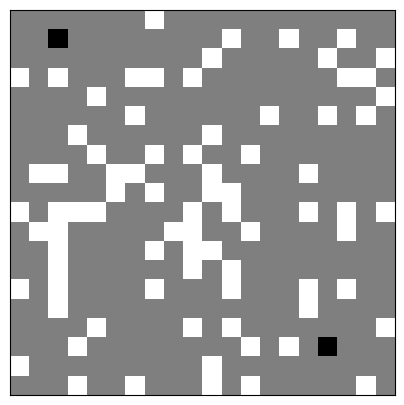

In [25]:
fig, axs = plt.subplots(figsize=(5,5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames = MAX_ITERATIONS)

In [28]:
print(all_grid)

                                                  Grid
0    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
1    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
2    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
3    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
4    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
..                                                 ...
195  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
196  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
197  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
198  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...
199  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,...

[200 rows x 1 columns]


In [18]:
anim